In [86]:
import os
import time
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
#To load the file enter the path here
img_path = '..img'
xml_path= '..xml'
#tmc preprocessing
#extract data from xml and save to json
#convert img binary files to compressed numpy arrays with npz format

tree = ET.parse(xml_path)
root = tree.getroot()
dic = {}
coords = {}
for i in root[1][5][1][1]:
    coords[i.tag[40:]] = float(i.text)
offset = float(root[2][1][0].text)
shape = (int(root[2][1][4][1].text),int(root[2][1][5][1].text))
pix_res = float(root[1][5][0][13].text)
dic['coords'] = coords
dic['offset'] = offset
dic['shape'] = shape
dic['pix_res'] = pix_res
    
#convert the binary .img file to compressed npz array 
dtype = np.dtype('<u2') # big-endian unsigned integer (1byte)
fid = open(img_path, 'rb')
data = np.fromfile(fid, dtype)
image = data.reshape(shape)

In [45]:
#For demonstration
image=np.load('better_cropped_tmc.npz')["arr_0"]

In [72]:
#Helper functions

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  hr_image=tf.image.grayscale_to_rgb(hr_image)
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)

def slice(image,dim=128):
  img = Image.fromarray(np.uint8(image)) 
  width = img.width
  height = img.height
  x=width//dim
  y=height//dim
  for i in range(1,x+1):
    for j in tqdm(range(1,y+1)):
      left=dim*(i-1)
      right=left+dim
      top=dim*(j-1)
      bottom=top+dim
      img1=img.crop((left,top,right,bottom))
      img1=np.array(img1)
      sliced_path="slices"
      if 'slices' not in os.listdir():
        os.mkdir("slices/")
      img_name=str(i)+"_"+str(j)+'.png'
      cv2.imwrite(os.path.join(sliced_path , img_name), img1)
      hr_image = preprocess_image('slices/'+img_name)
      sr_image = model(hr_image)
      high_image = model(sr_image)
      save_image(tf.squeeze(high_image), filename="slices/"+img_name.split('.')[0])
      
      


In [56]:
model=hub.load("model/")

In [83]:
slice(image)

100%|██████████| 39/39 [00:00<00:00, 218.34it/s]


In [120]:
tmc2_patch = cv2.imread('patch.png')
output=cv2.imread('output.png')

In [124]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image,cmap='gray')
  plt.axis("off")
  plt.title(title)

In [143]:
for i in range(0,len(os.listdir('slices'))):
  dim = 128*16
  img= Image.fromarray(np.uint8(image)) 
  width = img.width*16
  height = img.height*16
  x=width//dim
  y=height//dim
  final_image = np.array([])
  vstacks = np.array([])
  for i in range(1,x+1):
    hstacks = np.array([])
    for j in range(1,y+1):
      name = "slices/"+f"{i}_{j}" + ".png"
      left=dim*(i-1)
      right=left+dim
      top=dim*(j-1)
      bottom=top+dim
      img1=cv2.imread(name)
      if j == 1: 
        hstacks = img1
      else:
        hstacks = np.concatenate((hstacks,img1), axis=0)
    if i==1:
      vstacks = hstacks
    else:
      vstacks = np.concatenate((vstacks,hstacks), axis=1)

  final_image = vstacks

In [149]:
out = Image.fromarray(tf.cast(final_image, tf.uint8).numpy())
out.save('final_image.tif')

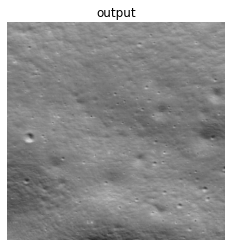

In [150]:
plot_image(out,"output")

#scores and metrics

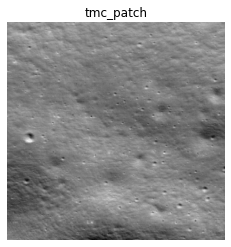

In [125]:
plot_image(tmc2_patch,"tmc_patch")

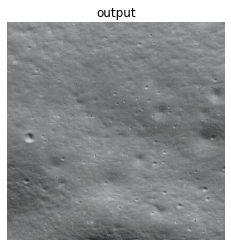

In [147]:
plot_image(output,"output")

In [ ]:
# this shows an example of the metrics of ohrc and tmc both placed in this folder
ohrc=np.load('ch2_ohr_ncp_20200825T1127278043_d_img_d18.npz')['arr_0']
ohrc = Image.fromarray(np.uint8(ohrc)).convert('RGB')
for i in range(1,2):
    for j in range(1,6):
        left=2048*(i-1)
        right=left+2048
        top=2048*(j-1)
        bottom=top+2048
        ohrc1=ohrc.crop((left,top,right,bottom))
        ohrc1=np.array(ohrc1)
        out_img="ohrc"+str(i)+"_"+str(j)+".png"
        path=r"ohrc_mapped"
        cv2.imwrite(os.path.join(path , out_img), ohrc1)

In [76]:
tmc2=cv2.imread('final_image.png')
tmc2.shape

(79872, 6144, 3)

In [21]:
output=cv2.imread('slices/1_1.jpg')
ohrc_patch=cv2.imread('ohrc_mapped/ohrc1_1.png')

PSNR

In [25]:
psnr = tf.image.psnr(
    tf.clip_by_value(output, 0, 255),
    tf.clip_by_value(ohrc_patch, 0, 255), max_val=255)
print("PSNR Achieved of generated image with actual OHRC images : %f" % psnr)

PSNR Achieved of generated image with actual OHRC images : 13.596362


SSIM

In [24]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [26]:
print("ssim of generated image with actual OHRC images : " ,ssim(output,ohrc_patch))

ssim of generated image with actual OHRC images :  0.6130291788295056
